---------
***Sampling from latent space of images***

-----

- The key idea is to develop a low dimensional latent space of representations where any point can be mapped to a real looking image. 
- The model which can take a point from latent space and generate a real image is called decoder(autoencoders), or generators(GANs). 
- VAEs are great for learning latent spaces which are well structured, where specific actions encode a meaningful axis of variation in data.
- GANs generate highly realistic images but the latent space they come from may nit be highlt structured and have continuity. 


-----
***Concept vectors for image editing***

------
- Given a latent space of representations, or any embedding space, certain directions in space may encode interesting axes of variation in the original data.
- Example - In a latent space of images of face, there may be smile vectors, so if there is a vector z for a particular space, then z+s would correspond to the same face along with smiling expression. 
- Once we have identified such vectors, image editing becomes a lot easier as we project them into the latent space, moving the representations in a meaningful way, and then decoding them into image space. 
- There are concept features for esentially any independent dimension of variation in image space-adding a sunglass, turning male face to female face, and so on.

-----
***Variational Autoencoders***

-----
- These are very appropriate for the task of image editing using concept vectors. 
- They are a modeern take on autoencoders- a type of network that aims to encode an input to a low-dimensional latent space and then decode it back. 
- ***Autoencoder*** - Takes an image maps it to latent space via a encoder module, and then decodes it back to the same dimensions as the original image, via a decoder module. By adding constraints to the encoder network various interesting latent representations can be learnt.  THis latent space is usually a compressed representation of the data. Using a vanilla autoencoder don't lead to a particularly useful or nicely structured latent spaces. 
- Here the ***VAEs*** come to picture as they use statistical magic that forces them to learn continous, highly structured latent spaces. 
- A VAE instead of just compressing the image, converts the image into the parameters of the statistical distribution: a mean and variance. 
- The VAE then samples one mean and variannce from the distribution and decodes it back to the original image. 
- The stochasticity of the process improves robustness and forces the latent space to encode meaningful representations everywhere: every spot sampled from latent space is decoded to a valid output. 

----
***High level view of VAE Processing -***
- An encoder module turns the input samples *input_img* into two parameters in the latent space of representaions, *z_mean*, and *z_log_variance*.
- You randomly sample a point z from the latent normal distribution that's assumed to generate the input image, via *z_mean + exp(z_log_variance)*epsilon*, where *epsilon* is a random tensor of small values. 
- A decoder module maps this point in the latent space back to the original input image. 
-----

- Use of Epsilon - Since the epsilon is a random value, it ensures that every point that is close to the latent location of encoded location of encoded image can be decoded to something similar to the that image, thus forcing the latent space to be continous. 

- So two close points in the latent space will return very close outputs. 
- Continuity, combined with the low dimensionality of the latent space, forces every direction in the latent space to encode a meaningful axis of variation of the data, making the latent space very structured and highly suitable to manipulation via concept vectors. 
- The paprameters of the VAE are trained via two loss functions: a reconstruction loss that forces the decoded samples to match the initial inputs, and a regularization loss that helps learn well formed latent spacesand reduces overfitting to the training data. 


The following is a very high level psedo code of the Architecture - 
```python
z_mean, z_log_variance = encoder(input_img)
z = z_mean + exp(z_log_variance)*epsilon
reconstructed_img = decoder(z)
model = Model(input_img, reconstructed_img)
```

Following we discuss the implementation of the VAE model - 

----
***VAE encoder network***

-----

In [1]:
import keras 
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np 

Using TensorFlow backend.


In [2]:
img_shape = (28,28,1)
batch_size = 16
### DImensionality of latent space(2D plane)
latent_dim = 2 

In [3]:
input_img = layers.Input(shape = img_shape)
x = layers.Conv2D(32,3,padding = 'same', activation = 'relu')(input_img)
x = layers.Conv2D(64,3,padding = 'same', activation = 'relu', strides = (2,2))(x)
x = layers.Conv2D(64,3,padding = 'same', activation = 'relu')(x)
x = layers.Conv2D(64,3,padding = 'same', activation = 'relu')(x)
shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation = 'relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


Now, now we need a layer to create a letent space point z using the z_mean and z_log_var. Since, Keras does not have a layer for that and it requires everything to be layerso we can custom build a layer in the following way. 

In [4]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape= (K.shape(z_mean)[0], latent_dim), mean = 0. , stddev = 1.)
    return z_mean + K.exp(z_log_var)*epsilon

In [5]:
z = layers.Lambda(sampling)([z_mean, z_log_var])

----
***VAE decoder network***

-----

In [6]:
decoder_input = layers.Input(K.int_shape(z)[1:])

### Upsamples the input
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation = 'relu')(decoder_input)
### Reshapes the flattened vector back to the image, i.e. esentially reversing what we did in encoder
x = layers.Reshape(shape_before_flattening[1:])(x)

### Using the Conv2DTranspose and COnv2D layer to decode z into a feature map of same size as input image
x = layers.Conv2DTranspose(32,3, padding='same', activation = 'relu', strides = (2,2))(x)
x = layers.Conv2D(1,3,padding = 'same', activation = 'sigmoid')(x)

In [7]:
decoder  = Model(decoder_input, x)
z_decoded = decoder(z)

In [8]:
def vae_loss(x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        ### The reconstruction loss
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        ### The KL Divergence loss to make sure that the latent space is continous, and
        ### the model learns meaningful representations in latent space
        k1_loss = -5e-4*K.mean(1+z_log_var-K.square(z_mean)-K.exp(z_log_var), axis=1)
        return K.mean(xent_loss + k1_loss)

-----
***Training the VAE***

------

In [9]:
from keras.datasets import mnist

vae = Model(input_img, z_decoded)
vae.compile(optimizer = 'rmsprop', loss = vae_loss)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [10]:
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 28, 28, 32)    320                                          
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 14, 14, 64)    18496                                        
____________________________________________________________________________________________________
conv2d_3 (Conv2D)                (None, 14, 14, 64)    36928                                        
___________________________________________________________________________________________

In [11]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))


vae.fit(x_train, x_train,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 23s - loss: 0.2090 - val_loss: 0.1962
Epoch 2/10
60000/60000 [==============================] - 21s - loss: 0.1923 - val_loss: 0.1917
Epoch 3/10
60000/60000 [==============================] - 22s - loss: 0.1879 - val_loss: 0.1881
Epoch 4/10
60000/60000 [==============================] - 21s - loss: 0.1854 - val_loss: 0.1843
Epoch 5/10
60000/60000 [==============================] - 21s - loss: 0.1837 - val_loss: 0.1848
Epoch 6/10
60000/60000 [==============================] - 20s - loss: 0.1824 - val_loss: 0.1815
Epoch 7/10
60000/60000 [==============================] - 20s - loss: 0.1815 - val_loss: 0.1807
Epoch 8/10
60000/60000 [==============================] - 20s - loss: 0.1807 - val_loss: 0.1814
Epoch 9/10
60000/60000 [==============================] - 20s - loss: 0.1800 - val_loss: 0.1805
Epoch 10/10
60000/60000 [==============================] - 20s - loss: 0.1794 - val_lo

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm 

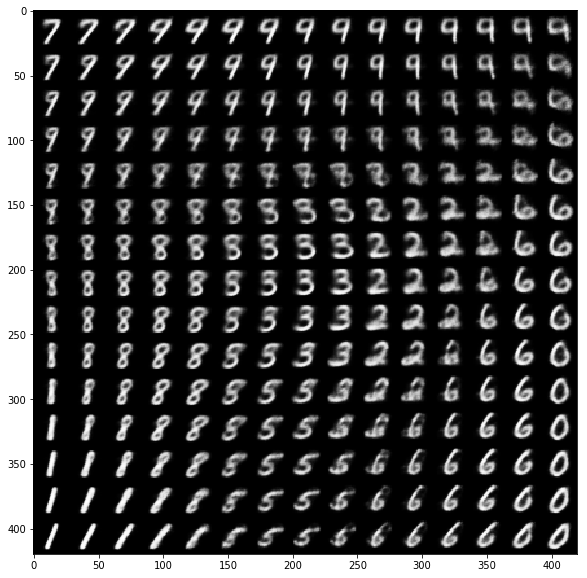

In [13]:
n = 15
digit_size = 28
figure = np.zeros((digit_size*n, digit_size*n))

### Transforms linearly spaced coordinated using Scipy ppf function to produce values of the 
### Latent variable z(because the proior of latent space is Gaussian)
grid_x = norm.ppf(np.linspace(0.05,0.95,n))
grid_y = norm.ppf(np.linspace(0.05,0.95,n))

for i,yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([xi,yi])
        ### Repeats z multiple times to form a batch
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size,2)
        x_decoded = decoder.predict(z_sample, batch_size = batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i*digit_size:(i+1)*digit_size,
              j*digit_size:(j+1)*digit_size] = digit
plt.figure(figsize = (10,10))
plt.imshow(figure, cmap = 'Greys_r')
plt.show()